In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import numpy as np
import scipy as sp
import pandas as pd
import functools as fts
import multiprocessing as mp
from tqdm.notebook import tqdm
from tqdm.contrib import tzip, tenumerate, tmap

from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.storagelevel import StorageLevel
from pyspark.sql.functions import col
import pyspark.sql.types as pstype
import pyspark.sql.functions as F
import pyspark as ps

import matplotlib as mlt
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML
import japanize_matplotlib

from time_series_model import *

%matplotlib inline
%matplotlib ipympl

In [2]:
ps_conf = ps.SparkConf().set("spark.logConf", "false")\
            .set("spark.executor.memory", "12g")\
            .set("spark.driver.memory", "4g")\
            .set("spark.executor.cores", "7")\
            .set("spark.sql.shuffle.partitions", "500")\
            .set("spark.executor.extraJavaOptions", "-XX:+UseG1GC -XX:+UseStringDeduplication")\
            .set("spark.eventLog.gcMetrics.youngGenerationGarbageCollectors", "G1 Young Generation")\
            .set("spark.eventLog.gcMetrics.oldGenerationGarbageCollectors", "G1 Old Generation")\
			.set("spark.logConf", "false")
spark = SparkSession.builder.config(conf=ps_conf).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/11 15:09:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
SPECIFIED_PATH = "csv_data/"
SPECIFIED_DATE = "20240918"
SPECIFIED_CSV  = SPECIFIED_PATH + SPECIFIED_DATE

In [4]:
input_path = SPECIFIED_CSV + "_c-united_config.csv"
df_config  = spark.read.option("inferSchema", "True").option("header", "True").csv(input_path)
df_config.persist(StorageLevel.MEMORY_AND_DISK_DESER)

utid_list = df_config.select("unit_id").drop_duplicates().rdd.flatMap(lambda x: x).collect()
spid_list = df_config.select("shop_id").drop_duplicates().rdd.flatMap(lambda x: x).collect()

In [5]:
#pos data 前処理
input_path  = SPECIFIED_CSV + "_pos_data_table.csv"
df_pos_data = spark.read.option('inferSchema', 'True').option('header', 'True').csv(input_path)\
				.select(
					"shop_id",
                    "レシートＮｏ．",
                    "商品種別",
                    "商品コード",
                    F.regexp_replace(col("商品名称（または券名称）"), "[ 　]", "").alias("商品名称（または券名称）"),
                    "オーダー時刻",
                    "単価",
                    "数量",
                    "合計金額",
                    "date"
				)\
				.filter(col("商品名称（または券名称）") != "")\
				.groupBy("shop_id", "date", "レシートＮｏ．").agg(
                    F.last("オーダー時刻").alias("オーダー時刻"),
                    F.sum(F.when(col("商品種別") == "Y", 1).otherwise(0)).alias("レシートあたりのセット商品の数"),
                    F.sum("数量").alias("総売上点数"),
                    F.sum("合計金額").alias("総売上"),
				)\
                .withColumn("レシートあたりのセット商品の数", F.when(col("レシートあたりのセット商品の数") == 0, 1)
                            								.otherwise(col("レシートあたりのセット商品の数")))\
                .withColumn("オーダー時刻", (F.col("オーダー時刻") / 100).cast("int"))\
                .withColumnRenamed("レシートあたりのセット商品の数", "来店者数")\
                .withColumnRenamed("オーダー時刻", "hour")
df_pos_data = df_pos_data.groupBy("shop_id", "date", "hour").agg(
                    F.sum("来店者数").alias("来店者数"),
                    F.sum("総売上点数").alias("総売上点数"),
                    F.sum("総売上").alias("総売上"),
				)\
                .select(["shop_id", "date", "hour", "来店者数", "総売上点数", "総売上"])\
                .orderBy(col("shop_id").asc(), col("date").asc(), col("hour").asc())
df_pos_data.show()


+-------+----------+----+--------+----------+------+
|shop_id|      date|hour|来店者数|総売上点数|総売上|
+-------+----------+----+--------+----------+------+
|   1189|2023-10-10|   6|       1|         1|   360|
|   1189|2023-10-10|   7|      56|        98| 43340|
|   1189|2023-10-10|   8|      50|        84| 36170|
|   1189|2023-10-10|   9|      66|       404|156520|
|   1189|2023-10-10|  10|      62|       129| 57640|
|   1189|2023-10-10|  11|      52|       120| 66465|
|   1189|2023-10-10|  12|     107|       206| 99340|
|   1189|2023-10-10|  13|      97|       166| 76190|
|   1189|2023-10-10|  14|      92|       185| 90990|
|   1189|2023-10-10|  15|     102|       176| 77170|
|   1189|2023-10-10|  16|     102|       204| 90260|
|   1189|2023-10-10|  17|      69|       174| 80205|
|   1189|2023-10-10|  18|      77|       125| 60590|
|   1189|2023-10-10|  19|      67|       133| 61540|
|   1189|2023-10-10|  20|      41|        74| 34710|
|   1189|2023-10-10|  21|      13|        26| 11895|
|   1

In [6]:
df_pos_data = df_pos_data\
    				.withColumn("date", F.from_unixtime(F.unix_timestamp("date") + F.col("hour") * 3600))\
                    .drop("hour")\
                    .orderBy(col("shop_id").asc(), col("date").asc())
df_pos_data.show()

+-------+-------------------+--------+----------+------+
|shop_id|               date|来店者数|総売上点数|総売上|
+-------+-------------------+--------+----------+------+
|   1189|2023-10-10 06:00:00|       1|         1|   360|
|   1189|2023-10-10 07:00:00|      56|        98| 43340|
|   1189|2023-10-10 08:00:00|      50|        84| 36170|
|   1189|2023-10-10 09:00:00|      66|       404|156520|
|   1189|2023-10-10 10:00:00|      62|       129| 57640|
|   1189|2023-10-10 11:00:00|      52|       120| 66465|
|   1189|2023-10-10 12:00:00|     107|       206| 99340|
|   1189|2023-10-10 13:00:00|      97|       166| 76190|
|   1189|2023-10-10 14:00:00|      92|       185| 90990|
|   1189|2023-10-10 15:00:00|     102|       176| 77170|
|   1189|2023-10-10 16:00:00|     102|       204| 90260|
|   1189|2023-10-10 17:00:00|      69|       174| 80205|
|   1189|2023-10-10 18:00:00|      77|       125| 60590|
|   1189|2023-10-10 19:00:00|      67|       133| 61540|
|   1189|2023-10-10 20:00:00|      41|     

In [7]:
df_pos_data = df_pos_data\
					.join(df_config.select(["shop_id", "caption"]), on="shop_id", how="inner")\
                    .select(["shop_id", "caption", "date", "来店者数", "総売上点数", "総売上"])\
                    .orderBy(col("shop_id").asc(), col("date").asc())
df_pos_data.show()

+-------+-------------------------------------+-------------------+--------+----------+------+
|shop_id|                              caption|               date|来店者数|総売上点数|総売上|
+-------+-------------------------------------+-------------------+--------+----------+------+
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 06:00:00|       1|         1|   360|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 07:00:00|      56|        98| 43340|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 08:00:00|      50|        84| 36170|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 09:00:00|      66|       404|156520|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 10:00:00|      62|       129| 57640|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 11:00:00|      52|       120| 66465|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 12:00:00|     107|       206| 99340|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 13:00:00|      97|       166| 76190|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 14:00:00|      92|       185| 90990|
|   1189|カフェ・ド・クリエグランサンシャ

In [8]:
pd_pos_data  = df_pos_data.select(["shop_id", "caption", "date", "来店者数"]).toPandas()
pd_tmp_data1 = pd_pos_data[pd_pos_data["shop_id"] == 1189] # カフェ・ド・クリエグランサンシャイン通り店
pd_tmp_data2 = pd_pos_data[pd_pos_data["shop_id"] == 1616] # カフェ・ド・クリエ日比谷通り内幸町店
pd_tmp_data3 = pd_pos_data[pd_pos_data["shop_id"] == 1428] # カフェ・ド・クリエ札幌オーロラタウン店
pd_tmp_data4 = pd_pos_data[pd_pos_data["shop_id"] == 1550] # カフェ・ド・クリエ博多大博通店
pd_pos_data  = pd.merge(pd_tmp_data1, pd_tmp_data2, on="date", how="inner", suffixes=['_1', '_2'])
pd_pos_data  = pd.merge(pd_pos_data,  pd_tmp_data3, on="date", how="inner", suffixes=['_2', '_3'])
pd_pos_data  = pd.merge(pd_pos_data,  pd_tmp_data4, on="date", how="inner", suffixes=['_3', '_4'])
pd_pos_data  = pd_pos_data[["date", "来店者数_1", "来店者数_2", "来店者数_3", "来店者数_4"]]
pd_pos_data  = pd_pos_data.rename(columns={
    								"来店者数_1": "カフェ・ド・クリエグランサンシャイン通り店",
                                    "来店者数_2": "カフェ・ド・クリエ日比谷通り内幸町店",
                                    "来店者数_3": "カフェ・ド・クリエ札幌オーロラタウン店",
                                    "来店者数_4": "カフェ・ド・クリエ博多大博通店"
                                })
pd_pos_data  = pd_pos_data[[
    				"date",
                    "カフェ・ド・クリエグランサンシャイン通り店",
                    "カフェ・ド・クリエ日比谷通り内幸町店",
                    "カフェ・ド・クリエ札幌オーロラタウン店",
                    "カフェ・ド・クリエ博多大博通店"
                ]]
del pd_tmp_data1
del pd_tmp_data2
del pd_tmp_data3
del pd_tmp_data4
pd_pos_data

24/10/11 15:09:16 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


,date,カフェ・ド・クリエグランサンシャイン通り店,カフェ・ド・クリエ日比谷通り内幸町店,カフェ・ド・クリエ札幌オーロラタウン店,カフェ・ド・クリエ博多大博通店
0,2023-10-10 07:00:00,56,45,14,20
1,2023-10-10 08:00:00,50,45,14,23
2,2023-10-10 09:00:00,66,12,15,26
3,2023-10-10 10:00:00,62,13,15,16
4,2023-10-10 11:00:00,52,45,36,19
...,...,...,...,...,...
3827,2024-09-15 13:00:00,103,18,33,29
3828,2024-09-15 14:00:00,127,10,25,20
3829,2024-09-15 15:00:00,120,23,42,27
3830,2024-09-15 16:00:00,125,16,27,15


In [9]:
x_data = pd_pos_data[["カフェ・ド・クリエグランサンシャイン通り店", "カフェ・ド・クリエ日比谷通り内幸町店", "カフェ・ド・クリエ札幌オーロラタウン店", "カフェ・ド・クリエ博多大博通店"]].values.tolist()
x_train, x_test = x_data[0:3600], x_data[3600:]

In [10]:
from statsmodels.tsa.vector_ar.var_model import VAR

var_model = VAR(x_test)

res = var_model.fit(4)
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 11, Oct, 2024
Time:                     15:09:17
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    19.9126
Nobs:                     228.000    HQIC:                   19.3025
Log likelihood:          -3379.51    FPE:                1.60040e+08
AIC:                      18.8898    Det(Omega_mle):     1.20033e+08
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        27.857328         6.240630            4.464           0.000
L1.y1         0.632764         0.073471            8.612           0.000
L1.y2        -0.104481         0.101303           -1.031           0.302
L1.y3         0.771506

In [11]:
res = var_model.select_order(maxlags=20)
print(res.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        20.62       20.68   8.996e+08       20.64
1        19.25      19.56*   2.284e+08       19.37
2        19.19       19.76   2.155e+08       19.42
3        19.09       19.92   1.960e+08       19.43
4        18.90       19.98   1.622e+08      19.34*
5        18.96       20.29   1.728e+08       19.50
6        18.88       20.46   1.588e+08       19.52
7        18.90       20.73   1.619e+08       19.64
8        18.87       20.96   1.581e+08       19.71
9        18.81       21.15   1.496e+08       19.76
10      18.78*       21.37  1.458e+08*       19.83
11       18.80       21.65   1.507e+08       19.96
12       18.83       21.94   1.564e+08       20.09
13       18.84       22.20   1.594e+08       20.20
14       18.88       22.49   1.674e+08       20.34
15       18.88       22.74   1.686e+08       20.44
16       18.94       23.05   1.

In [12]:
lag = res.selected_orders["hqic"]
var_fit = var_model.fit(lag)
print(var_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 11, Oct, 2024
Time:                     15:09:17
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    19.9126
Nobs:                     228.000    HQIC:                   19.3025
Log likelihood:          -3379.51    FPE:                1.60040e+08
AIC:                      18.8898    Det(Omega_mle):     1.20033e+08
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        27.857328         6.240630            4.464           0.000
L1.y1         0.632764         0.073471            8.612           0.000
L1.y2        -0.104481         0.101303           -1.031           0.302
L1.y3         0.771506

In [13]:
print("グレンジャー因果性テスト(p値 = 0.05)")
print("")

t = var_fit.test_causality(causing=0, caused=1, kind="wald")
print("カフェ・ド・クリエグランサンシャイン通り店" + " → " + "カフェ・ド・クリエ日比谷通り内幸町店")
print("F検定量:", t.test_statistic, "  ", "p値:", t.pvalue)
print("グレンジャー因果性有り" if t.pvalue < 0.05 else "グレンジャー因果性無し")
print("")

t = var_fit.test_causality(causing=0, caused=2, kind="wald")
print("カフェ・ド・クリエグランサンシャイン通り店" + " → " + "カフェ・ド・クリエ札幌オーロラタウン店")
print("F検定量:", t.test_statistic, "  ", "p値:", t.pvalue)
print("グレンジャー因果性有り" if t.pvalue < 0.05 else "グレンジャー因果性無し")
print("")

t = var_fit.test_causality(causing=0, caused=3, kind="wald")
print("カフェ・ド・クリエグランサンシャイン通り店" + " → " + "カフェ・ド・クリエ博多大博通店")
print("F検定量:", t.test_statistic, "  ", "p値:", t.pvalue)
print("グレンジャー因果性有り" if t.pvalue < 0.05 else "グレンジャー因果性無し")
print("")

t = var_fit.test_causality(causing=1, caused=0, kind="wald")
print("カフェ・ド・クリエ日比谷通り内幸町店" + " → " + "カフェ・ド・クリエグランサンシャイン通り店")
print("F検定量:", t.test_statistic, "  ", "p値:", t.pvalue)
print("グレンジャー因果性有り" if t.pvalue < 0.05 else "グレンジャー因果性無し")
print("")

t = var_fit.test_causality(causing=1, caused=2, kind="wald")
print("カフェ・ド・クリエ日比谷通り内幸町店" + " → " + "カフェ・ド・クリエ札幌オーロラタウン店")
print("F検定量:", t.test_statistic, "  ", "p値:", t.pvalue)
print("グレンジャー因果性有り" if t.pvalue < 0.05 else "グレンジャー因果性無し")
print("")

t = var_fit.test_causality(causing=1, caused=3, kind="wald")
print("カフェ・ド・クリエ日比谷通り内幸町店" + " → " + "カフェ・ド・クリエ博多大博通店")
print("F検定量:", t.test_statistic, "  ", "p値:", t.pvalue)
print("グレンジャー因果性有り" if t.pvalue < 0.05 else "グレンジャー因果性無し")
print("")

t = var_fit.test_causality(causing=2, caused=0, kind="wald")
print("カフェ・ド・クリエ札幌オーロラタウン店" + " → " + "カフェ・ド・クリエグランサンシャイン通り店")
print("F検定量:", t.test_statistic, "  ", "p値:", t.pvalue)
print("グレンジャー因果性有り" if t.pvalue < 0.05 else "グレンジャー因果性無し")
print("")

t = var_fit.test_causality(causing=2, caused=1, kind="wald")
print("カフェ・ド・クリエ札幌オーロラタウン店" + " → " + "カフェ・ド・クリエ日比谷通り内幸町店")
print("F検定量:", t.test_statistic, "  ", "p値:", t.pvalue)
print("グレンジャー因果性有り" if t.pvalue < 0.05 else "グレンジャー因果性無し")
print("")

t = var_fit.test_causality(causing=2, caused=3, kind="wald")
print("カフェ・ド・クリエ札幌オーロラタウン店" + " → " + "カフェ・ド・クリエ博多大博通店")
print("F検定量:", t.test_statistic, "  ", "p値:", t.pvalue)
print("グレンジャー因果性有り" if t.pvalue < 0.05 else "グレンジャー因果性無し")
print("")

t = var_fit.test_causality(causing=3, caused=0, kind="wald")
print("カフェ・ド・クリエ博多大博通店" + " → " + "カフェ・ド・クリエグランサンシャイン通り店")
print("F検定量:", t.test_statistic, "  ", "p値:", t.pvalue)
print("グレンジャー因果性有り" if t.pvalue < 0.05 else "グレンジャー因果性無し")
print("")

t = var_fit.test_causality(causing=3, caused=1, kind="wald")
print("カフェ・ド・クリエ博多大博通店" + " → " + "カフェ・ド・クリエ日比谷通り内幸町店")
print("F検定量:", t.test_statistic, "  ", "p値:", t.pvalue)
print("グレンジャー因果性有り" if t.pvalue < 0.05 else "グレンジャー因果性無し")
print("")

t = var_fit.test_causality(causing=3, caused=2, kind="wald")
print("カフェ・ド・クリエ博多大博通店" + " → " + "カフェ・ド・クリエ札幌オーロラタウン店")
print("F検定量:", t.test_statistic, "  ", "p値:", t.pvalue)
print("グレンジャー因果性有り" if t.pvalue < 0.05 else "グレンジャー因果性無し")
print("")

グレンジャー因果性テスト(p値 = 0.05)

カフェ・ド・クリエグランサンシャイン通り店 → カフェ・ド・クリエ日比谷通り内幸町店
F検定量: 4.635668874817948    p値: 0.326762345267295
グレンジャー因果性無し

カフェ・ド・クリエグランサンシャイン通り店 → カフェ・ド・クリエ札幌オーロラタウン店
F検定量: 3.806783960337086    p値: 0.43278583603033605
グレンジャー因果性無し

カフェ・ド・クリエグランサンシャイン通り店 → カフェ・ド・クリエ博多大博通店
F検定量: 4.942986381802971    p値: 0.29319763501408636
グレンジャー因果性無し

カフェ・ド・クリエ日比谷通り内幸町店 → カフェ・ド・クリエグランサンシャイン通り店
F検定量: 23.13044900434933    p値: 0.00011924963797201408
グレンジャー因果性有り

カフェ・ド・クリエ日比谷通り内幸町店 → カフェ・ド・クリエ札幌オーロラタウン店
F検定量: 23.792081926531598    p値: 8.791671596748437e-05
グレンジャー因果性有り

カフェ・ド・クリエ日比谷通り内幸町店 → カフェ・ド・クリエ博多大博通店
F検定量: 27.338227703123057    p値: 1.698177807511731e-05
グレンジャー因果性有り

カフェ・ド・クリエ札幌オーロラタウン店 → カフェ・ド・クリエグランサンシャイン通り店
F検定量: 32.92138882516267    p値: 1.2395748607920298e-06
グレンジャー因果性有り

カフェ・ド・クリエ札幌オーロラタウン店 → カフェ・ド・クリエ日比谷通り内幸町店
F検定量: 22.141770062529694    p値: 0.00018780832295900129
グレンジャー因果性有り

カフェ・ド・クリエ札幌オーロラタウン店 → カフェ・ド・クリエ博多大博通店
F検定量: 29.8005527948189    p値: 5.373990020069364e-06
グレンジャー因果性有り

カフェ・ド・クリエ博多大博

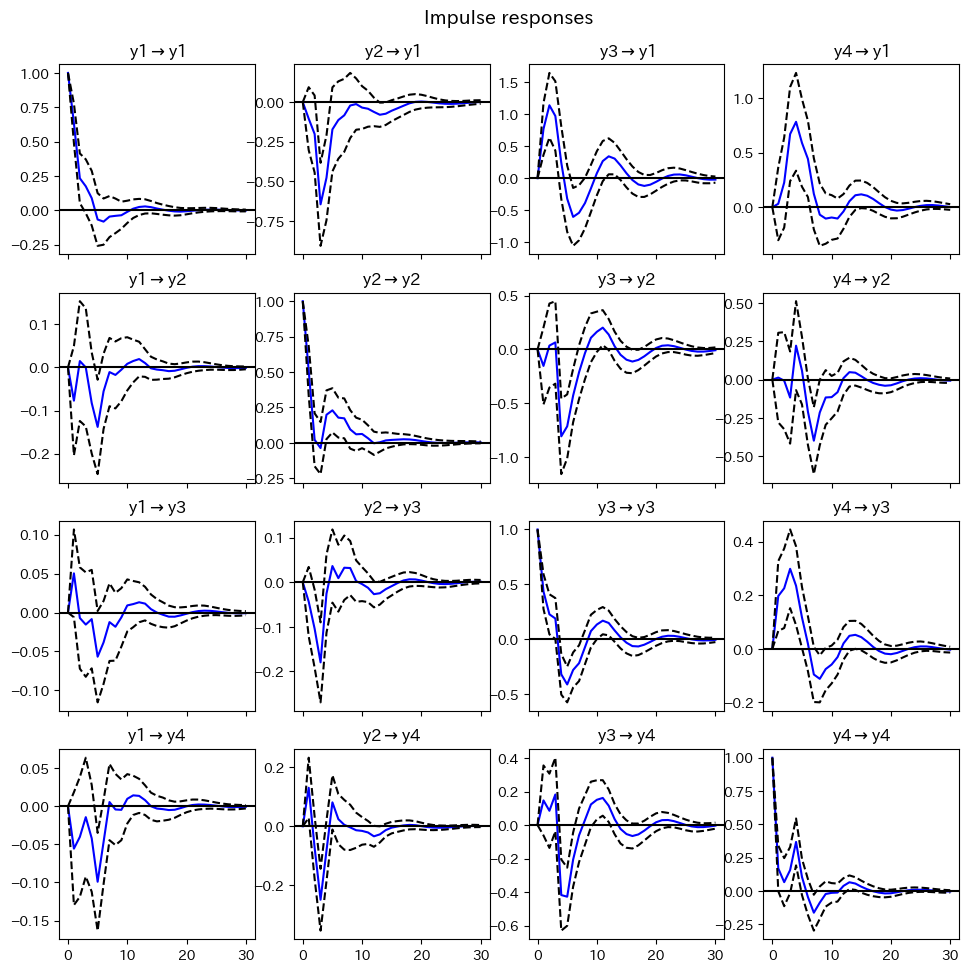

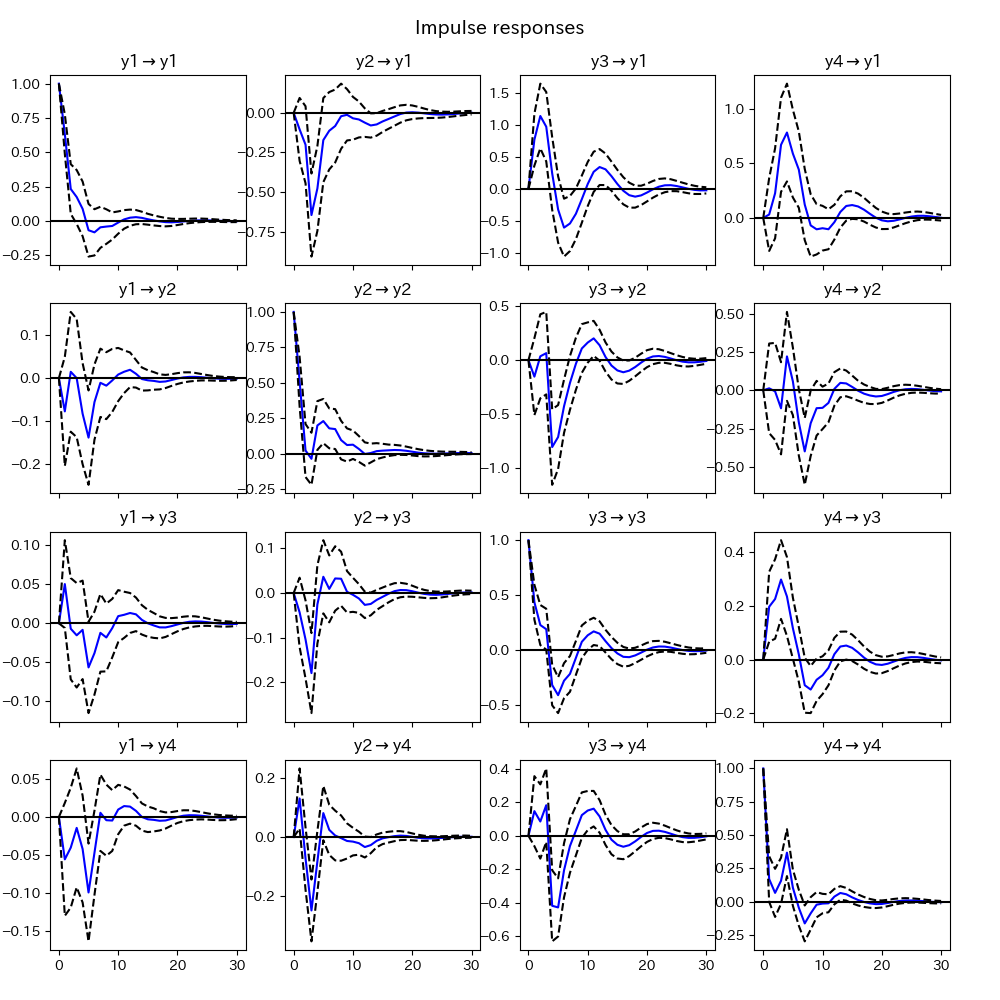

In [14]:
IRF = var_fit.irf(30)
IRF.plot(orth=False)

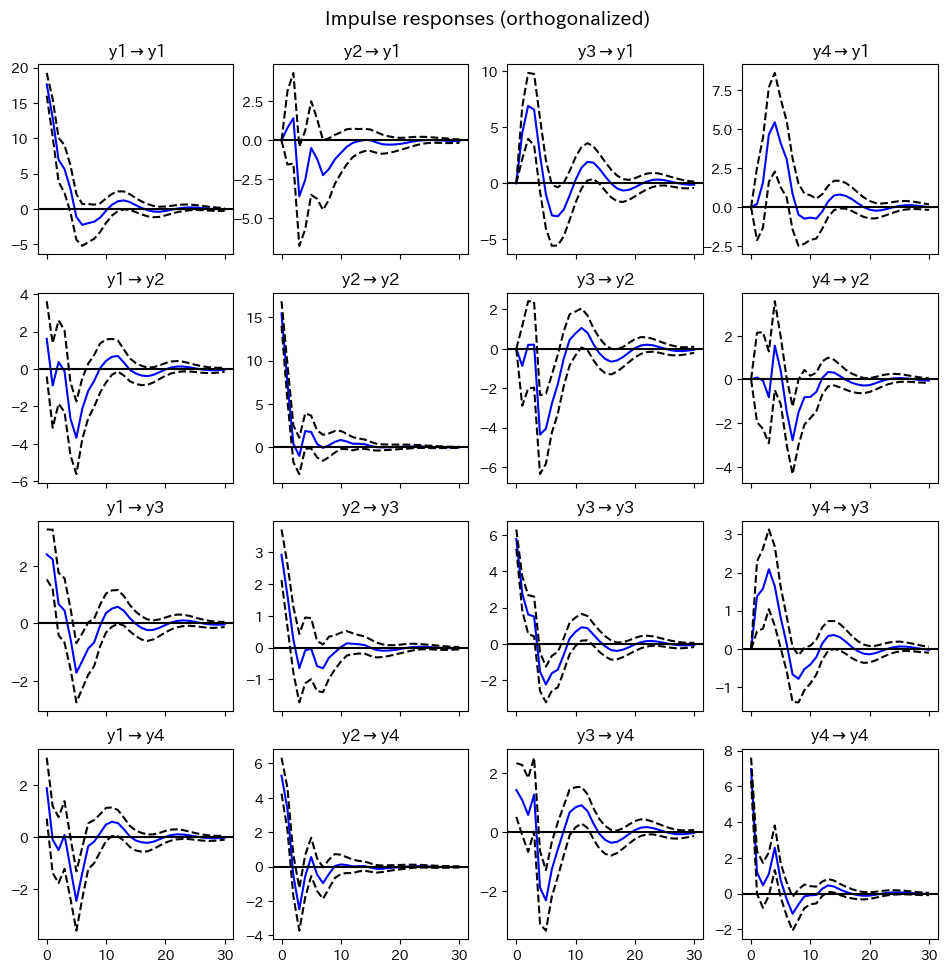

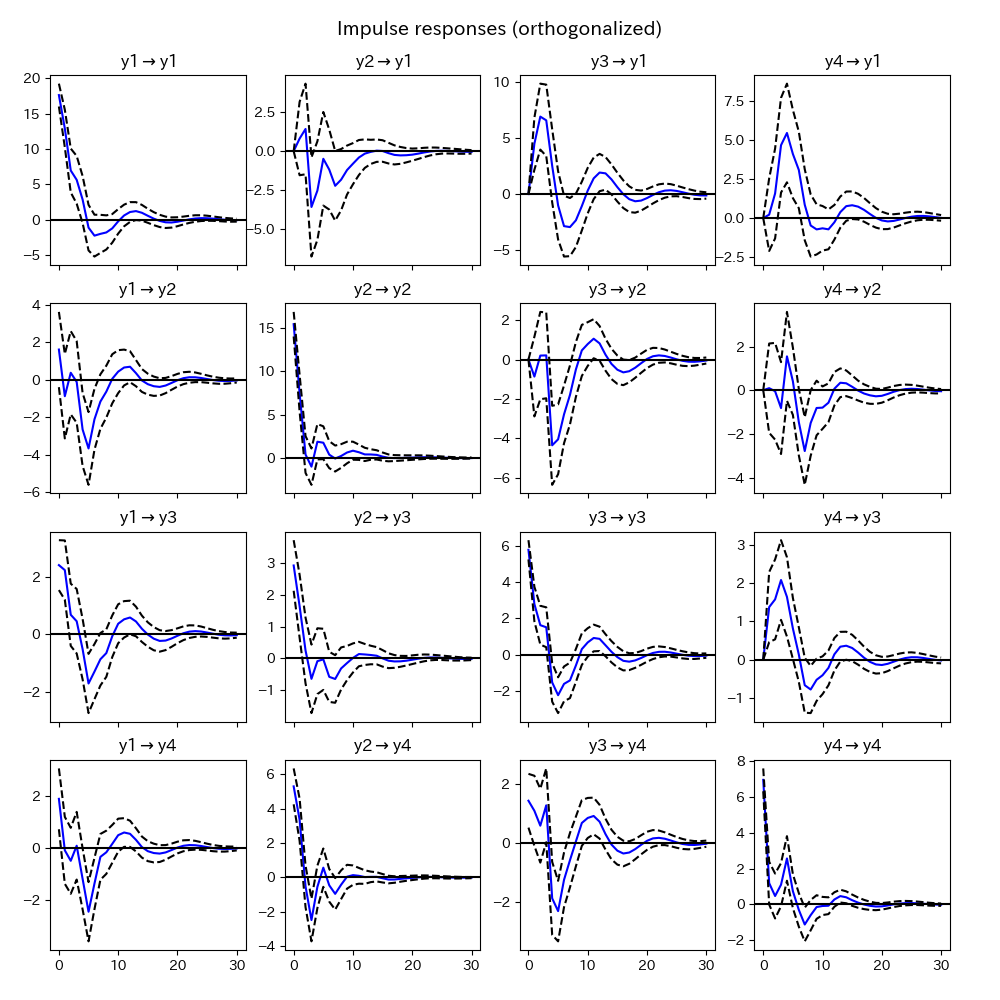

In [17]:
IRF = var_fit.irf(30)
#for idx in range(0, 31):
#    for idx2 in range(0, 4):
#        IRF.orth_irfs[idx, :, idx2] = IRF.orth_irfs[idx, :, idx2] / var_fit.stderr_endog_lagged[4*(var_fit.k_ar - 1):][idx2, idx2]

#for idx in range(0, 4):
#    IRF.orth_irfs[:, :, idx] = IRF.orth_irfs[:, :, idx] / IRF.orth_irfs[0, idx, idx]
IRF.plot(orth=True)

FEVD for y1
            y1        y2        y3        y4
0     1.000000  0.000000  0.000000  0.000000
1     0.957902  0.001315  0.040686  0.000097
2     0.877427  0.004487  0.113867  0.004219
3     0.786376  0.021855  0.157541  0.034228
4     0.744703  0.028815  0.155511  0.070972
5     0.727856  0.028404  0.152956  0.090784
6     0.712299  0.029285  0.158556  0.099861
7     0.701276  0.034632  0.165588  0.098504
8     0.694829  0.038129  0.169731  0.097311
9     0.692786  0.039661  0.170163  0.097390
10    0.691843  0.040369  0.170031  0.097756
11    0.689788  0.040422  0.171768  0.098022
12    0.687112  0.040214  0.175140  0.097533
13    0.684757  0.039979  0.178135  0.097129
14    0.683251  0.039829  0.179479  0.097441
15    0.682517  0.039766  0.179641  0.098075
16    0.682084  0.039758  0.179522  0.098636
17    0.681666  0.039798  0.179643  0.098893
18    0.681281  0.039850  0.179977  0.098891
19    0.681023  0.039901  0.180250  0.098826
20    0.680900  0.039946  0.180336  0.09881

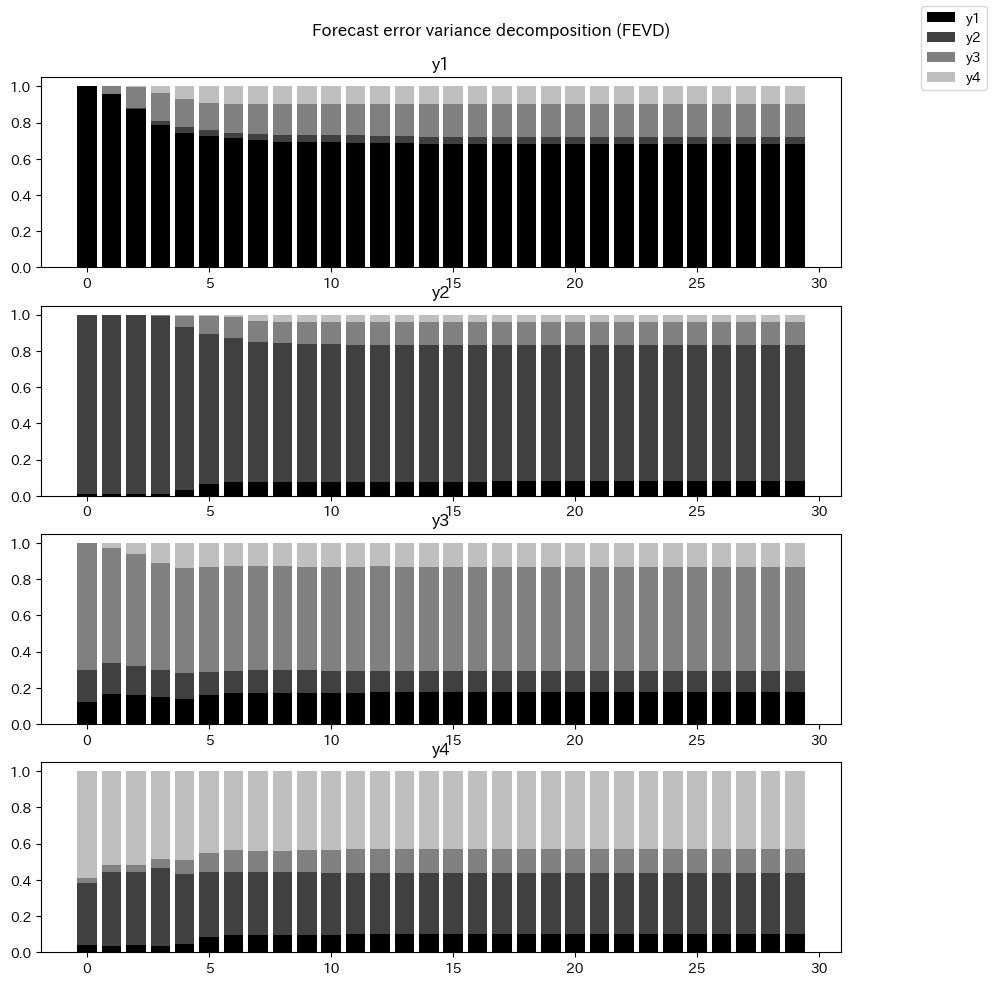

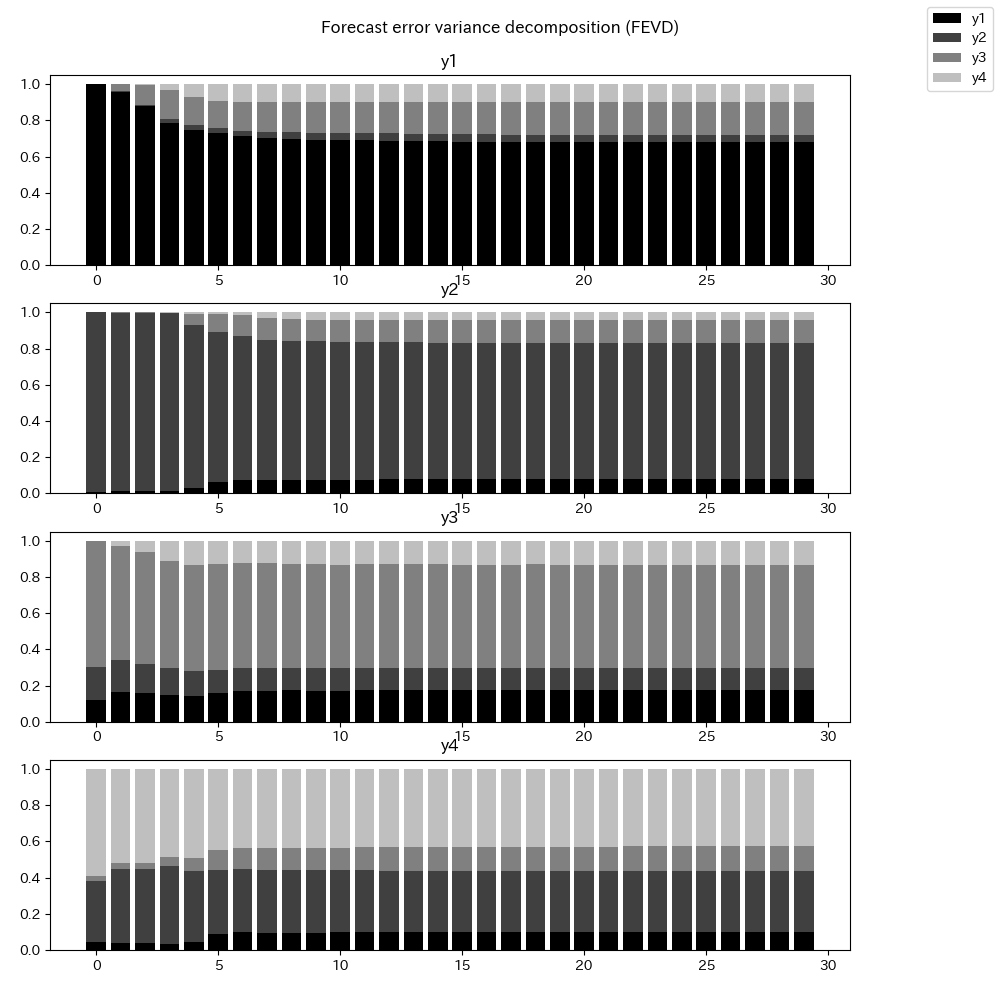

In [16]:
FEVD = var_fit.fevd(30)
print(FEVD.summary())
FEVD.plot()